In [1]:
# Preprocessing
import pandas as pd
import tables
import time
import numpy as np
import gc
from tqdm import tqdm_notebook
from data_processing import get_data_2dprojection
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
from tensorflow.python.client import device_lib
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [4]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15359983512893291425, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 8466068276
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6413444848261054512
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 28a6:00:00.0, compute capability: 3.7"]

In [5]:
tf.__version__

'1.10.0'

In [6]:
import keras
import keras.layers as L
from keras.models import Sequential
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [7]:
from keras import layers
from keras import models


#
# image dimensions
#

img_height = 150
img_width = 150
img_channels = 2

#
# network params
#

cardinality = 1


def residual_network_tail(x):
    """
    ResNeXt by default. For ResNet set `cardinality` = 1 above.
    
    """
    def add_common_layers(y):
        y = layers.BatchNormalization()(y)
        y = layers.LeakyReLU()(y)

        return y

    def grouped_convolution(y, nb_channels, _strides):
        # when `cardinality` == 1 this is just a standard convolution
        if cardinality == 1:
            return layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
        
        assert not nb_channels % cardinality
        _d = nb_channels // cardinality

        # in a grouped convolution layer, input and output channels are divided into `cardinality` groups,
        # and convolutions are separately performed within each group
        groups = []
        for j in range(cardinality):
            group = layers.Lambda(lambda z: z[:, :, :, j * _d:j * _d + _d])(y)
            groups.append(layers.Conv2D(_d, kernel_size=(3, 3), strides=_strides, padding='same')(group))
            
        # the grouped convolutional layer concatenates them as the outputs of the layer
        y = layers.concatenate(groups)

        return y

    def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1), _project_shortcut=False):
        """
        Our network consists of a stack of residual blocks. These blocks have the same topology,
        and are subject to two simple rules:
        - If producing spatial maps of the same size, the blocks share the same hyper-parameters (width and filter sizes).
        - Each time the spatial map is down-sampled by a factor of 2, the width of the blocks is multiplied by a factor of 2.
        """
        shortcut = y

        # we modify the residual building block as a bottleneck design to make the network more economical
        y = layers.Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        y = add_common_layers(y)

        # ResNeXt (identical to ResNet when `cardinality` == 1)
        y = grouped_convolution(y, nb_channels_in, _strides=_strides)
        y = add_common_layers(y)

        y = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        # batch normalization is employed after aggregating the transformations and before adding to the shortcut
        y = layers.BatchNormalization()(y)

        # identity shortcuts used directly when the input and output are of the same dimensions
        if _project_shortcut or _strides != (1, 1):
            # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
            # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
            shortcut = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        y = layers.add([shortcut, y])

        # relu is performed right after each batch normalization,
        # expect for the output of the block where relu is performed after the adding to the shortcut
        y = layers.LeakyReLU()(y)

        return y

    # conv1
    x = layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(x)
    x = add_common_layers(x)

    # conv2
    x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    for i in range(3):
        project_shortcut = True if i == 0 else False
        x = residual_block(x, 128, 256, _project_shortcut=project_shortcut)

    # conv3
    for i in range(4):
        # down-sampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 256, 512, _strides=strides)

    # conv4
    for i in range(6):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 512, 1024, _strides=strides)

    # conv5
    #for i in range(3):
    #    strides = (2, 2) if i == 0 else (1, 1)
    #    x = residual_block(x, 1024, 2048, _strides=strides)

    return x

In [9]:
LTRAIN = '/mnt/iprovilkov/data_dir/npdata/'
rg = np.arange(0,100000,15000)
MAXR=17200

In [11]:
#DATA_DIR = '/storage/home/vprov/JUNO/JUNO_students/data/'
#TRAIN_DIR = '/srv/hd5/data/vprov/data/phase_1/train/'
TRAIN_DIR = '~/data/data_dir/'
tr_lpmt_hits = pd.read_hdf(TRAIN_DIR + 'lpmt_hits.h5', mode='r')
tr_spmt_hits = pd.read_hdf(TRAIN_DIR + 'spmt_hits.h5', mode='r')
tr_pos = pd.read_csv(TRAIN_DIR + 'lpmt_pos.csv') 
tr_spmt_pos = pd.read_csv(TRAIN_DIR + 'spmt_pos.csv') 
tr_true_info = pd.read_csv(TRAIN_DIR + 'true_info.csv')

In [13]:
for start, end  in zip(rg[:-1], rg[1:]):
    data_lpmt, event_to_id = get_data_2dprojection(tr_lpmt_hits[(tr_lpmt_hits['event'] >= start) & (tr_lpmt_hits['event'] < end)
                                                                & (tr_lpmt_hits['isDN'] == False)], 
                                                tr_spmt_hits[(tr_spmt_hits['event'] >= start) & (tr_spmt_hits['event'] < end) 
                                                            & (tr_spmt_hits['isDN'] == False)], 
                                                tr_pos, 
                                                tr_true_info[(tr_true_info.R<=MAXR) 
                                                             & (tr_true_info['evtID'] >= start) 
                                                             & (tr_true_info['evtID'] < end)],
                                                edge_size=70,
                                                use_spmt=False,
                                                time='min')
    np.save(LTRAIN + '1_' + str(start) + 'without_noise' + '_time_70', data_lpmt)

Make projection
Starting cycle...



Make projection
Starting cycle...



Make projection
Starting cycle...



Make projection
Starting cycle...



Make projection
Starting cycle...



Make projection
Starting cycle...


In [51]:
import matplotlib.pyplot as plt

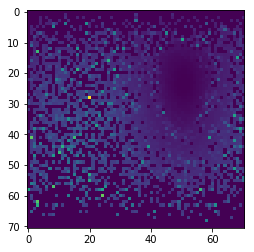

In [19]:
plt.imshow(data_lpmt[0][:,:,1])

In [52]:
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
import keras.layers as L
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.engine.input_layer import Input

In [53]:
EDGE_SIZE = 70

In [54]:
inputs = Input(shape=(EDGE_SIZE+1,EDGE_SIZE+1,2))
base_model = residual_network_tail(inputs)

In [55]:
regularizer = l2(1e-2)

In [57]:
x = GlobalAveragePooling2D()(base_model)
# let's add a fully-connected layer
x = L.Dropout(0.5)(x)
x = Dense(1024, activation='elu', kernel_regularizer=regularizer)(x)
x = L.Dropout(0.5)(x)
x = Dense(1024, activation='elu', kernel_regularizer=regularizer)(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(1, kernel_regularizer=regularizer)(x)

In [58]:
model = Model(inputs=inputs, outputs=predictions)

In [59]:
model.layers[70].trainable

True

In [61]:
model.compile(optimizer=Adam(lr=4e-4, decay=5e-5), loss='mean_squared_error')

In [62]:
model.build(input_shape=(None, EDGE_SIZE+1,EDGE_SIZE+1,2))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 71, 71, 2)    0                                            
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 36, 36, 64)   6336        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, 36, 36, 64)   256         conv2d_44[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_41 (LeakyReLU)      (None, 36, 36, 64)   0           batch_normalization_44[0][0]     
__________________________________________________________________________________________________
max_poolin

In [63]:
#X_train, X_test, y_train, y_test = train_test_split(data_lpmt, y_val, test_size=0.2, random_state=45)

In [64]:
logdir = 'log_2904E_without_time_min_resnet.csv'

In [66]:
!rm log_2904E_without_time_min_resnet.csv

In [67]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger(logdir, append=True, separator=';')

In [68]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.000001)

In [69]:
#out = model.fit(X_train, y_train, batch_size=32, 
#                epochs=30, 
#                callbacks=[csv_logger, reduce_lr], 
#                validation_data=(X_test, y_test))

In [70]:
TRAIN_DIR = '~/data/data_dir/'
tr_true_info = pd.read_csv(TRAIN_DIR + 'true_info.csv')

In [73]:
epochs = [5,5,5,3,3,3,1,1,1,1,1,1,1]

In [ ]:
import gc
for i in range(len(epochs)):
    for start, end in zip(rg[:-1], rg[1:]):
        print("ITERATION: ", i)
        data_lpmt = np.load(LTRAIN + '1_' + str(start) +'without_noise_time_70.npy')
        ys = tr_true_info[(tr_true_info['evtID'] >= start) 
                            & (tr_true_info['evtID'] < end)]
        mask = (ys.R <= MAXR)
        data_lpmt = data_lpmt[mask]
        y_val = ys[mask][['E']].values
        
        X_train, X_test, y_train, y_test = train_test_split(data_lpmt, y_val, test_size=0.2, random_state=45)
        out = model.fit(X_train, y_train, batch_size=32, 
                epochs=epochs[i],
                callbacks=[csv_logger, reduce_lr],
                validation_data=(X_test, y_test),
                shuffle=True)
    gc.collect()

ITERATION:  0
Train on 11020 samples, validate on 2756 samples
Epoch 1/5
11020/11020 [==============================] - 147s 13ms/step - loss: 22.1922 - val_loss: 29.9313
Epoch 2/5
11020/11020 [==============================] - 134s 12ms/step - loss: 16.9725 - val_loss: 15.0836
Epoch 3/5
11020/11020 [==============================] - 135s 12ms/step - loss: 13.5112 - val_loss: 11.9831
Epoch 4/5
11020/11020 [==============================] - 137s 12ms/step - loss: 10.5301 - val_loss: 9.1921
Epoch 5/5
11020/11020 [==============================] - 136s 12ms/step - loss: 8.0192 - val_loss: 7.1031
ITERATION:  0
Train on 10988 samples, validate on 2747 samples
Epoch 1/5
10988/10988 [==============================] - 136s 12ms/step - loss: 5.9660 - val_loss: 5.8100
Epoch 2/5
10988/10988 [==============================] - 136s 12ms/step - loss: 4.3199 - val_loss: 3.7235
Epoch 3/5
10988/10988 [==============================] - 137s 12ms/step - loss: 3.0840 - val_loss: 2.5786
Epoch 4/5
10988/109

In [49]:
reduce_lr = keras.callbacks.LearningRateScheduler(lambda it: 1e-5, verbose=0)

In [81]:
import gc
for i in range(len(epochs)):
    for start, end in zip(rg[:-1], rg[1:]):
        print("ITERATION: ", i)
        data_lpmt = np.load(LTRAIN + '1_' + str(start) +'without_noise_time_70.npy')
        ys = tr_true_info[(tr_true_info['evtID'] >= start)
                            & (tr_true_info['evtID'] < end)]
        mask = (ys.R <= MAXR)
        data_lpmt = data_lpmt[mask]
        y_val = ys[mask][['E']].values
        
        X_train, X_test, y_train, y_test = train_test_split(data_lpmt, y_val, test_size=0.2, random_state=45)
        out = model.fit(X_train, y_train, batch_size=32, 
                epochs=1,
                callbacks=[csv_logger, reduce_lr],
                validation_data=(X_test, y_test),
                shuffle=True)
    gc.collect()

ITERATION:  0
Train on 11020 samples, validate on 2756 samples
Epoch 1/1
11020/11020 [==============================] - 128s 12ms/step - loss: 0.0523 - val_loss: 0.0309
ITERATION:  0
Train on 10988 samples, validate on 2747 samples
Epoch 1/1
10988/10988 [==============================] - 132s 12ms/step - loss: 0.0577 - val_loss: 0.0276
ITERATION:  0
Train on 11041 samples, validate on 2761 samples
Epoch 1/1
11041/11041 [==============================] - 135s 12ms/step - loss: 0.0497 - val_loss: 0.0352
ITERATION:  0
Train on 11036 samples, validate on 2760 samples
Epoch 1/1
11036/11036 [==============================] - 137s 12ms/step - loss: 0.0504 - val_loss: 0.0311
ITERATION:  0
Train on 11064 samples, validate on 2767 samples
Epoch 1/1
11064/11064 [==============================] - 138s 12ms/step - loss: 0.0471 - val_loss: 0.0315
ITERATION:  0
Train on 10959 samples, validate on 2740 samples
Epoch 1/1
10959/10959 [==============================] - 138s 13ms/step - loss: 0.0516 - val

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

In [39]:
cs = pd.read_csv(logdir, sep=';')

(0, 0.3)

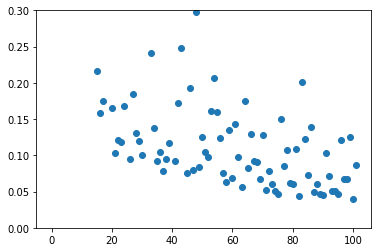

In [40]:
plt.scatter(np.arange(0, cs.shape[0]), cs['val_loss'].values)
plt.ylim(0,0.3)

(0, 0.5)

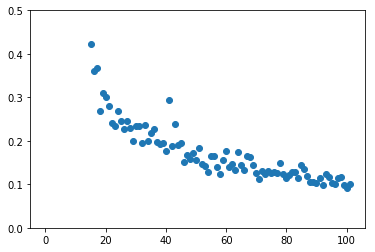

In [41]:
plt.scatter(np.arange(0, cs.shape[0]), cs['loss'].values)
plt.ylim(0,0.5)

In [86]:
#cs.plot(x='epoch',y='val_loss')
#plt.ylim((0, 100000))

In [42]:
model.save_weights('ResNet70.h5')

In [18]:
model.load_weights('2_04_E_wn_time.h5')

In [43]:
print("+")

+


In [44]:
with open("ResNet70.json", "w") as json_file:
    json_file.write(model.to_json())

In [45]:
from sklearn.metrics.pairwise import paired_euclidean_distances
from sklearn.metrics import mean_squared_error

In [46]:
# in mm
#test_results = paired_euclidean_distances(model.predict(X_test), y_test)

In [47]:
preds = np.maximum(model.predict(X_test), 0)
test_resultsE = mean_squared_error(preds[:,0], y_test[:,0])
#test_resultsR = mean_squared_error(preds[:,1], y_test[:,1])

In [48]:
test_resultsE.mean()

0.06166417211994886

(-0.05, 0.05)

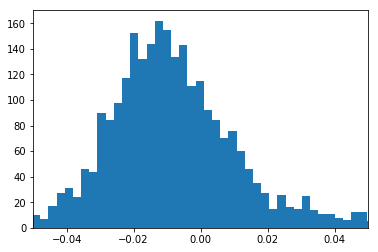

In [90]:
plt.hist((preds[:,0] - y_test[:,0])/y_test[:,0], bins=200)
plt.xlim((-0.05,0.05))

In [77]:
%run root_reader.py

In [91]:
from tqdm import tqdm

In [92]:
root_data_path = '/mnt/iprovilkov/data_dir/0MeV_lpmt_hits.h5'

In [93]:
def test_sigmas(model, test_dir='/mnt/iprovilkov/data_dir/', test_column='E', MAXR=MAXR, 
                time=False, recompute=False):
    sigmas = {}
    MSEs = {}
    predictions = {}
    CONST = 1.022
    for energy in tqdm(range(10)):
        try:
            if recompute:
                raise Exception("Recompute")
            if time:
                data_lpmt = np.load(test_dir + str(energy) + 'data_lpmt_time_70.npy')
            else:
                data_lpmt = np.load(test_dir + str(energy) + 'data_lpmt_70.npy')
            true_info = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'true_info.csv')
        except: 
            print("Compute...")
            lpmt_hits = pd.read_hdf(test_dir + str(energy)+'MeV_'+ 'lpmt_hits.h5', mode='r') 
            spmt_hits = pd.read_hdf(test_dir + str(energy)+'MeV_'+'spmt_hits.h5', mode='r')
            lpmt_hits = lpmt_hits[lpmt_hits.isDN==False]
            spmt_hits = spmt_hits[spmt_hits.isDN==False]
            pos = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'lpmt_pos.csv') 
            spmt_pos = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'spmt_pos.csv') 
            true_info = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'true_info.csv')
            if time:
                data_lpmt, event_to_id = get_data_2dprojection(lpmt_hits, 
                                    spmt_hits, 
                                    pos, 
                                    true_info,
                                                               edge_size = 70,
                                    use_spmt=True,
                                    time='min')
                np.save(test_dir+str(energy)+'data_lpmt_time', data_lpmt)
            else:
                data_lpmt, event_to_id = get_data_2dprojection(lpmt_hits, 
                                    spmt_hits, 
                                    pos, 
                                    true_info,
                                                               edge_size = 70,
                                    use_spmt=True)
                np.save(test_dir+str(energy)+'data_lpmt_70', data_lpmt)
        mask = (true_info.R<=MAXR)
        data_lpmt = data_lpmt[mask]
        true_info = true_info[mask]
        preds = np.maximum(model.predict(data_lpmt), 0)
        y_test = true_info[test_column]
        print(y_test.mean())
        predictions[energy] = preds
        MSEs[energy] = mean_squared_error(preds, y_test)
        # in percents
        sigmas[energy] = np.std(preds - y_test.mean()) / (energy + CONST)
    print("+")
    return sigmas, MSEs, predictions

In [94]:
sigmas, MSEs, predictions = test_sigmas(model, time=True, recompute=False)

 10%|█         | 1/10 [00:05<00:51,  5.73s/it]

0.5109988999999999


 20%|██        | 2/10 [00:12<00:49,  6.13s/it]

1.5109988697622994


 30%|███       | 3/10 [00:20<00:45,  6.56s/it]

2.5109990065502177


 40%|████      | 4/10 [00:29<00:43,  7.27s/it]

3.5109988987951803


 50%|█████     | 5/10 [00:38<00:38,  7.73s/it]

4.510998806956522


 60%|██████    | 6/10 [00:46<00:31,  7.99s/it]

5.510998686870312


 70%|███████   | 7/10 [00:54<00:23,  7.87s/it]

6.510998666593649


 80%|████████  | 8/10 [01:01<00:15,  7.71s/it]

7.510998798899285


 90%|█████████ | 9/10 [01:08<00:07,  7.54s/it]

8.510999212171052


100%|██████████| 10/10 [01:16<00:00,  7.45s/it]

9.510998837121212
+


In [96]:
sigmas, MSEs

({0: 0.037163364793923036,
  1: 0.025533723739794758,
  2: 0.019894986802343497,
  3: 0.021812371253848727,
  4: 0.015804200640526105,
  5: 0.014740303134015531,
  6: 0.017648635469790844,
  7: 0.01301565533770911,
  8: 0.012680327441734106,
  9: 0.013379843630873498},
 {0: 0.017202375713634876,
  1: 0.004614147252031656,
  2: 0.0036881720690961034,
  3: 0.008880604812317613,
  4: 0.009456578285544713,
  5: 0.012079708215017457,
  6: 0.021987777108686837,
  7: 0.017841089818711686,
  8: 0.020029285715083424,
  9: 0.03214037453128818})

In [77]:
sigmas, MSEs

({0: 0.03574577519221782,
  1: 0.02523249661887081,
  2: 0.01995606331893105,
  3: 0.02182584417097489,
  4: 0.015767612385113653,
  5: 0.01471381534258419,
  6: 0.017705963135648404,
  7: 0.01300192535354502,
  8: 0.012642709524714479,
  9: 0.013560269305244984},
 {0: 0.014009560962716586,
  1: 0.003995020872398612,
  2: 0.003779239030646516,
  3: 0.008931147205499,
  4: 0.009170935407985222,
  5: 0.011414065487719269,
  6: 0.021208103680256826,
  7: 0.017330066233361845,
  8: 0.020287351327648192,
  9: 0.031331244276456886})

In [49]:
sigmas

{0: 0.038474174890732814,
 1: 0.026154273827988597,
 2: 0.02210689825699236,
 3: 0.023699502174917113,
 4: 0.016853081270880265,
 5: 0.015424544066537142,
 6: 0.018125263604300206,
 7: 0.012623399265743912,
 8: 0.012157339131163536,
 9: 0.01369413145286455}

In [78]:
a = 2.8
b=0.59
c=0


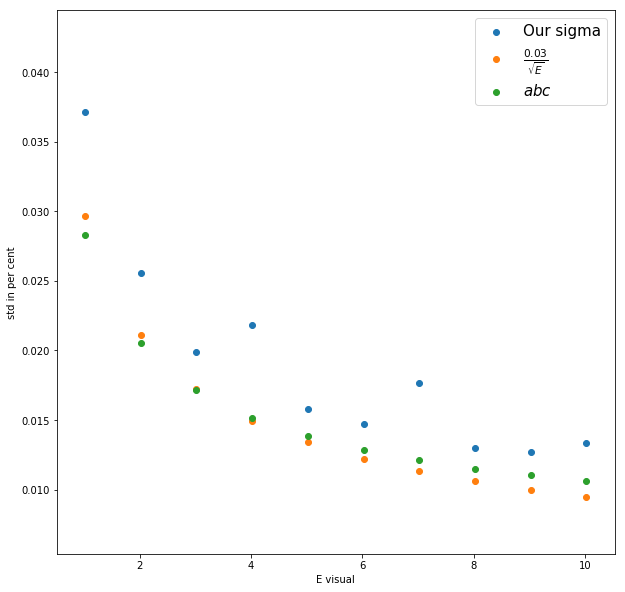

In [97]:
# Plot sigmas
Evis = np.array([en + 1.022  for en in range(10)])
Perc_sigmas = [sigmas[en] for en in range(10)]
perc_3_sqrt_E = [0.03 / np.sqrt(en) for en in Evis]
fig = plt.figure(figsize=(10,10))
plt.scatter(Evis, Perc_sigmas, label='Our sigma')
plt.scatter(Evis, perc_3_sqrt_E, label=r'$\frac{0.03}{\sqrt{E}}$')
plt.scatter(Evis, 0.01*np.sqrt((a/np.sqrt(Evis))**2 + b**2 + (c/Evis)**2), label=r'$abc$')
plt.ylabel("std in per cent")
plt.xlabel("E visual")
plt.legend(fontsize=15)

In [153]:
np.sqrt((a/np.sqrt(Evis))**2 + b**2 + (c/Evis)**2)

array([2.83184266, 2.05558974, 1.71534498, 1.51571071, 1.38174926,
       1.28452056, 1.21020289, 1.15126556, 1.10321662, 1.06319283])

In [128]:
true_info = pd.read_csv(TRAIN_DIR + str(1)+'MeV_'+'true_info.csv')

In [86]:
MSEs

{0: 0.32402012211672154,
 1: 0.283077267854172,
 2: 0.26076454010359984,
 3: 0.24662389940641563,
 4: 0.22839128695606983,
 5: 0.21886375239789502,
 6: 0.20932755816665902,
 7: 0.19612737804283614,
 8: 0.1803405524640515,
 9: 0.15392615773066362}

In [89]:
data_lpmt.shape

(13699, 151, 151, 1)

In [93]:
data_lpmt

169.0

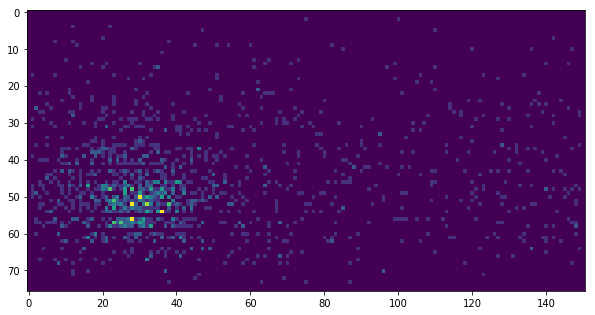

In [121]:
fig = plt.figure(figsize=(10,10))
plt.imshow(data_lpmt[49][::2,:,0])

In [167]:
ev_min = tr_spmt_hits[tr_spmt_hits.isDN==False][['event', 'hitTime']].groupby('event').min()

In [168]:
event2min = {id_: min_ for id_, min_ in zip(ev_min.index, ev_min.hitTime)}

In [170]:
ev_min[:3]

,hitTime
event,
0,24.623285
1,26.568943
2,23.950851


In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [95]:
test_dir='/mnt/iprovilkov/data_dir/'
test_column='E'
energy = 1
CONST = 1.022
data_lpmt = np.load(test_dir + str(1) + 'data_lpmt_time.npy')
true_info = pd.read_csv(TRAIN_DIR + str(1)+'MeV_'+'true_info.csv')
mask = (true_info.R<=MAXR)
data_lpmt = data_lpmt[mask]
true_info = true_info[mask]
preds = np.maximum(model.predict(data_lpmt), 0)
y_test = true_info[test_column]
print(y_test.mean())

1.5109988697622994


In [97]:
diff = (preds - y_test.mean()) / (energy + CONST)

In [104]:
mean_diff = (y_test.mean() - preds.mean()) 

In [105]:
diff_2 = (preds + mean_diff - y_test.mean()) / (energy + CONST)

In [112]:
np.std(diff_2)

0.030855266

In [113]:
np.std(diff)

0.030855266

Text(0.5, 0, 'Energy error, mEv')

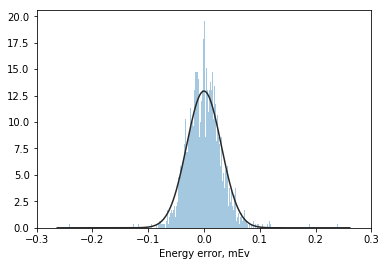

In [107]:
sns.distplot(diff_2, kde=False, fit=stats.norm, bins=300)
plt.xlim((-0.3,0.3))
plt.xlabel("Energy error, mEv")

In [109]:
import scipy.stats as sps

In [115]:
norm = sps.norm

In [122]:
norm.fit(diff)

(-0.014148425, 0.030855266)

In [98]:
# Make a submission
TEST_DIR = '/srv/hd5/data/vprov/data/phase_1/test/'
te_lpmt_hits = pd.read_hdf(TEST_DIR + 'test_l_hits.h5', mode='r')
te_spmt_hits = pd.read_hdf(TEST_DIR + 'test_s_hits.h5', mode='r')

In [99]:
len(te_lpmt_hits['event'].unique())

5000

In [101]:
te_data_lpmt, te_event_to_id = get_data_2dprojection(te_lpmt_hits, 
                                                              te_spmt_hits, 
                                                              tr_pos, 
                                                              tr_true_info,
                                                              use_spmt=True, time=True)

Make projection
Starting cycle...


In [102]:
te_data_lpmt.shape

(5000, 151, 151, 3)

In [91]:
#te_data_lpmt = te_data_lpmt.reshape((*te_data_lpmt.shape, 1))

In [103]:
test_answer = model.predict(te_data_lpmt)

In [104]:
test_answer = np.maximum(test_answer, 0)

In [105]:
test_answer[:3]

array([[3.1486816],
       [6.8654876],
       [2.4813795]], dtype=float32)

In [111]:
forR = pd.read_csv('./submissions/03_02_mix.csv')

In [112]:
forR[:3]

,E,R,evtID
0,13554.038,13554.038,16000
1,15458.701,15458.701,16001
2,8600.067,8600.067,16002


In [113]:
x = te_lpmt_hits["event"].unique()
pred = pd.DataFrame({
            "evtID": x,
            "R": forR['R'],
            "E": test_answer[:,0]
    })

In [114]:
pred[:3]

,E,R,evtID
0,3.148682,13554.038,16000
1,6.865488,15458.701,16001
2,2.481380,8600.067,16002


In [115]:
pred.to_csv('./submissions/03_02_mix.csv', index=None)

In [109]:
test_resultsE

0.10578900484730176

In [112]:
np.maximum(preds[:,0], 0) - y_test[:,0]

array([ 0.07827002,  0.16265111,  0.09557195, ...,  0.29406197,
        0.4023328 , -0.02289935])

Text(0.5,0,'Energy error, mEv')

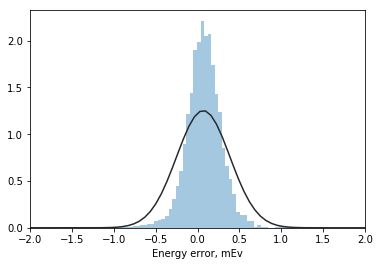

In [119]:
sns.distplot(np.maximum(preds[:,0], 0) - y_test[:,0], kde=False, fit=stats.norm, bins=300)
plt.xlim((-2,2))
plt.xlabel("Energy error, mEv")

In [122]:
(preds-y_test).mean() / y_test.mean()

0.012328221320621629

In [49]:
test_results.mean() / 10

40.478805095559686

In [53]:
results = model.predict(X_test)

In [54]:
xs = results[:,0] - y_test[:,0]

(-1000, 1000)

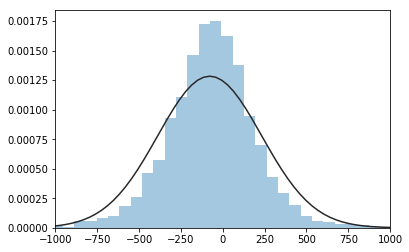

In [57]:
sns.distplot(xs, kde=False, fit=stats.norm, bins=100)
plt.xlim(-1000,1000)

In [59]:
abs(xs).mean()/10

21.422522304369796

In [ ]:
#json_file = open('model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
## load weights into new model
#loaded_model.load_weights("model.h5")
#print("Loaded model from disk")
# 
## evaluate loaded model on test data
#loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#score = loaded_model.evaluate(X, Y, verbose=0)

In [ ]:
# Adversarial example с нормальным текстом
# Кэширование перевода
# Bert в телефоне